# Task 3 - Yolo and Faster-R-CNN for Object Detection and Segmentation

## Imports

In [175]:
# Standard libraries
import os
import sys
import json
import ast
import pickle
import warnings


# Numerical and data manipulation libraries
import numpy as np
import pandas as pd
from collections import Counter
from scipy.optimize import linear_sum_assignment
from sklearn.cluster import KMeans

# Torch and related libraries
import torch
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import CocoDetection
from torchvision.transforms import functional as F
from torchvision.transforms import Compose, ToTensor
import torchvision.transforms as transforms
import torchvision.models as models

# Ultralytics for YOLO
import ultralytics
from ultralytics import YOLO

# Image processing libraries
import cv2
from PIL import Image

# Visualization libraries
import matplotlib.pyplot as plt
from IPython.display import display, Image
# from tqdm import tqdm

# Suppress all UserWarning messages
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Seed for reproducibility
np.random.seed(42)

## Image Functions

In [176]:
# Load an image from a file path
def LoadImage(path):
    return cv2.imread(path)

# Display an image already loaded in memory (as a numpy array)
def RenderImage(image, scale=1):
    
    if image.dtype == np.float64:
        image = cv2.convertScaleAbs(image)
        
    if len(image.shape) == 3 and image.shape[2] == 3:
        if np.array_equal(image[:, :, 0], image[:, :, 2]):
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    if scale != 1:
        new_size = (int(image.shape[1] * scale), int(image.shape[0] * scale))
        image = cv2.resize(image, new_size, interpolation=cv2.INTER_LINEAR)

    img_bytes = cv2.imencode('.jpg', image)[1].tobytes()
    display(Image(data=img_bytes))

## Bounding Box Functions

In [177]:
# Draw bounding boxes on an image as green rectangles
def DrawBBOnImage(img, bbs):
    img = img.copy()
    for bb in bbs:
        x1, y1, x2, y2 = [int(x) for x in bb]
        img = cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 1)
    return img

# Display an image with bounding boxes
def DisplayBBResults(img_path, bbs, scale=2):
    RenderImage(DrawBBOnImage(LoadImage(img_path), bbs), scale)

# Model Loading Functions

In [178]:
# Load a YOLO model from a file (trained on full Lego dataset - 5 epochs)
def LoadYoloModel():
    return YOLO('models/trained_yolo.pt')

# Load a Faster R-CNN model from a file (trained on full Lego dataset - 5 epochs)
def LoadFRCNNModel():
    def get_model(num_classes):
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        return model

    num_classes = 2 # 1 class (lego) + background
    model = get_model(num_classes)
    model.load_state_dict(torch.load('models/trained_faster.pth', map_location=torch.device('cpu')))
    model.eval() # Set model to evaluation mode (no training)
    return model

## Model Execution Functions

In [179]:
# Make a prediction using a YOLO model and return the bounding boxes of detected legos
def RunModelYolo(model, image_path, conf=0.25):
    results = model(image_path, conf=conf, verbose=False)
    bounding_boxes = results[0].boxes.xyxy.tolist()
    return bounding_boxes

# Make a prediction using a Faster R-CNN model and return the bounding boxes of detected legos
def RunModelFRCNN(model, image_path, conf=0.5):
    
    def predict(model, image_path):
        image = LoadImage(image_path)
        image_tensor = F.to_tensor(image).unsqueeze(0)
        with torch.no_grad():
            prediction = model(image_tensor)
        return prediction

    prediction = predict(model, image_path)[0]

    # Draw boxes on the image
    boxes = prediction['boxes']
    scores = prediction['scores']
    
    bounding_boxes = []

    for box, score in zip(boxes, scores):
        box = [int(i) for i in box.tolist()]
        if score > conf:
            bounding_boxes.append(box)

    return bounding_boxes

model = models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()
transform = transforms.Compose([transforms.ToTensor(),])
   
def ModelSegmentation(image):
    
    image = cv2.resize(image, (image.shape[1] * 5, image.shape[0] * 5)) 
    input_image = transform(image).unsqueeze(0)
    
    with torch.no_grad():
        predictions = model(input_image)

    if len(predictions[0]['scores']) > 0:
        scores = predictions[0]['scores']
        max_score_index = torch.argmax(scores).item()
        mask = predictions[0]['masks'][max_score_index, 0].detach().cpu().numpy()

        return mask

    return np.zeros(image.shape[:2], np.uint8)

## Image Segmentation Functions

In [180]:
# Get all images contained by each given bounding box
def GetBBImages(image, bbs, padding=0):
    bb_imgs = []
    for bb in bbs:
        x1, y1, x2, y2 = [int(x) for x in bb]
        # Adjusting bounding box coordinates with padding
        x1 -= padding
        y1 -= padding
        x2 += padding
        y2 += padding
        # Ensuring coordinates are within image bounds
        x1 = max(0, x1)
        y1 = max(0, y1)
        x2 = min(image.shape[1], x2)
        y2 = min(image.shape[0], y2)
        cropped = image[y1:y2, x1:x2]
        bb_imgs.append(cropped)
    return bb_imgs

def GetGrabCutMask(img):
    mask = np.zeros(img.shape[:2], np.uint8)
    bgModel = np.zeros((1, 65), np.float64)
    fgModel = np.zeros((1, 65), np.float64)
    rect = (0, 0, img.shape[1] - 1, img.shape[0] - 1)
    iterCount = 10
    cv2.grabCut(img, mask, rect, bgModel, fgModel, iterCount, cv2.GC_INIT_WITH_RECT)
    mask = np.where((mask == cv2.GC_FGD) | (mask == cv2.GC_PR_FGD), 1, 0).astype('uint8')
    return mask

# Apply image segmentation to single lego on an bb image
def ApplyLegoSegmentation(lego_img, showIntermediateImgs=False):
    
    if showIntermediateImgs:
        RenderImage(lego_img, 5)
    
    def reduce_colors_mean_shift(img, spatial_radius, color_radius):
        lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
        shifted_img = cv2.pyrMeanShiftFiltering(lab_img, spatial_radius, color_radius)
        return cv2.cvtColor(shifted_img, cv2.COLOR_Lab2BGR)
    
    spatial_radius = 50
    color_radius = 5
    lego_img = reduce_colors_mean_shift(lego_img, spatial_radius, color_radius)

    bbColorBlurQnt = 1

    fg_mask = np.zeros(lego_img.shape[:2], np.uint8)
    
    while fg_mask.sum() == 0:
        lego_img_blurred = cv2.GaussianBlur(lego_img, (bbColorBlurQnt, bbColorBlurQnt), 0)
        fg_mask = GetGrabCutMask(lego_img)
        bbColorBlurQnt -= 2
        if bbColorBlurQnt < 1 and fg_mask.sum() == 0:            
            # return a full mask
            return np.ones(lego_img.shape[:2], np.uint8)
    
    if showIntermediateImgs:
        masked = cv2.bitwise_and(lego_img_blurred, lego_img_blurred, mask=fg_mask)
        RenderImage(masked, 5)
        
        # Render fg_mask as binary
        RenderImage(fg_mask * 255, 5)
    
    return fg_mask


# Apply image segmentation to an image using the given bounding boxes
def ApplyImageSegmentation(image, bbs, showIntermediateImgs=False):
    bb_imgs = GetBBImages(image, bbs)
    masks = [ApplyLegoSegmentation(box_img, showIntermediateImgs) for box_img in bb_imgs]
    
    new_image = image.copy()
    
    for mask, bb in zip(masks, bbs):
        x1, y1, x2, y2 = [int(x) for x in bb]
        
        # Apply the neon effect to the bounding box
        for y in range(y1, y2):
            for x in range(x1, x2):
                if mask[y - y1, x - x1]:
                    neon = (new_image[y, x] + [255, 0, 255] ) / 2
                    new_image[y, x] = np.uint8(neon)
        
    RenderImage(new_image, 3)
    

## Model Evaluation Functions

In [181]:
df_gt = pd.read_csv('../data/values.csv') # Load the ground truth values

# Get all image IDs in the ground truth dataset
def GetAllFileNamesInDir(dir):
    file_names = []
    for filename in os.listdir(dir):
        if os.path.isfile(os.path.join(dir, filename)):
            file_names.append(filename)
    return file_names

# Get the ground truth bounding boxes for a given image ID
def GetGroundTruthBBs(image_id):
    global df_gt
    bbs_normalized = ast.literal_eval(df_gt[df_gt['id'] == image_id]['bb_list'].values[0])
    bbs = [[i*224 for i in bb] for bb in bbs_normalized] 
    return bbs

## Example Execution - Detection

Faster R-CNN:


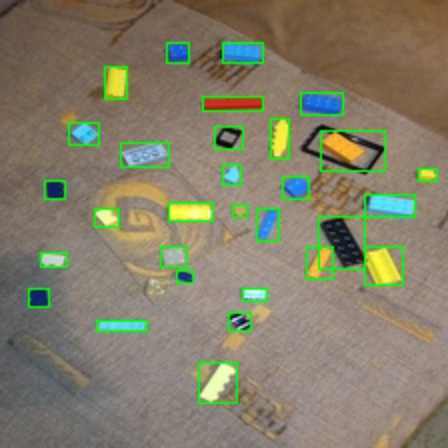

YOLO:


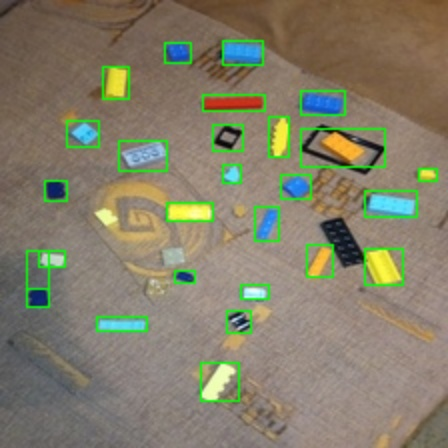

In [182]:
name = '32_1.jpg'
test_image = '../data/imgs/' + name

model_faster = LoadFRCNNModel()
model_yolo = LoadYoloModel()

bbs_faster = RunModelFRCNN(model_faster, test_image)
bbs_yolo = RunModelYolo(model_yolo, test_image)

print('Faster R-CNN:')
DisplayBBResults(test_image, bbs_faster)
print('YOLO:')
DisplayBBResults(test_image, bbs_yolo)

## Example Execution - Segmentation

In [183]:
# ApplyImageSegmentation(LoadImage(test_image), bbs_faster, True)

In [184]:
def kmeansBlur(img, kmeansBlurQuantity, kmeansClusterSize):
    blurred = cv2.GaussianBlur(img, (kmeansBlurQuantity, kmeansBlurQuantity), 0)

    pixels = blurred.reshape((-1, 3))
    pixels = np.float32(pixels)

    criteria = (cv2.TERM_CRITERIA_MAX_ITER, 200, 1.0)
    _, labels, centers = cv2.kmeans(pixels, kmeansClusterSize, None, criteria, 12, cv2.KMEANS_RANDOM_CENTERS)

    centers = np.uint8(centers)
    segmented_data = centers[labels.flatten()]
    segmented_image = segmented_data.reshape((img.shape))

    return segmented_image

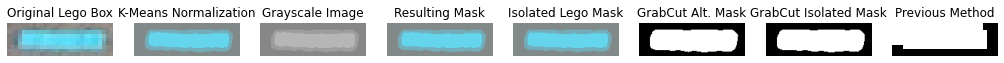

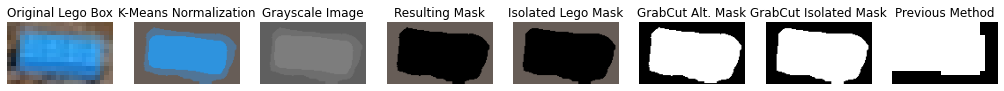

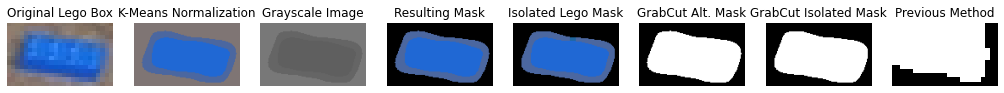

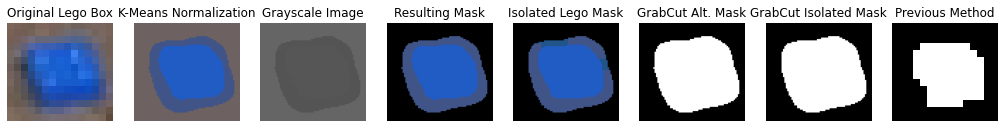

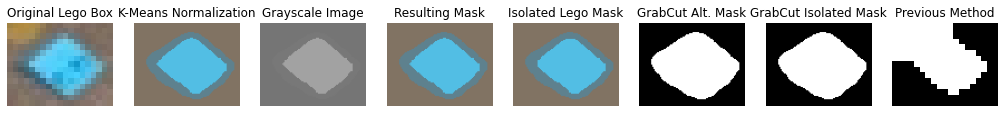

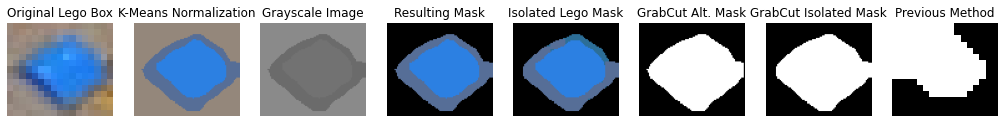

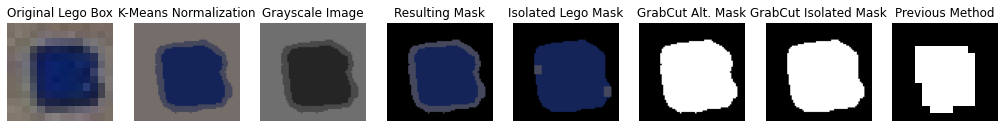

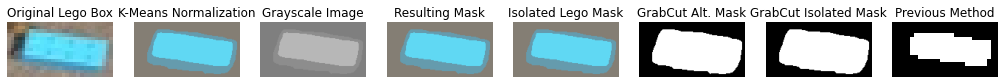

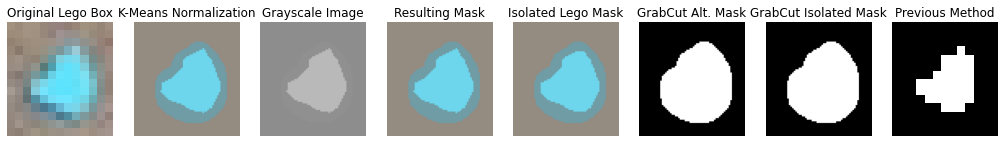

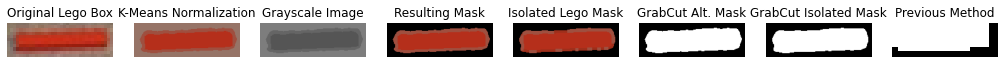

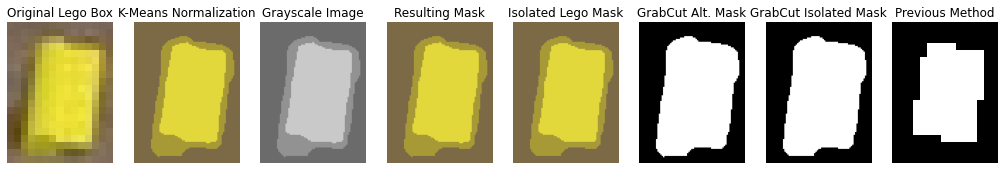

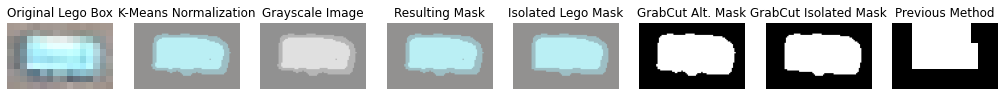

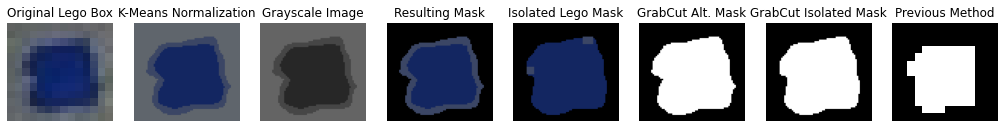

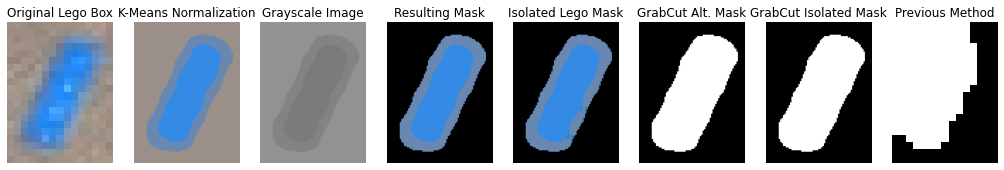

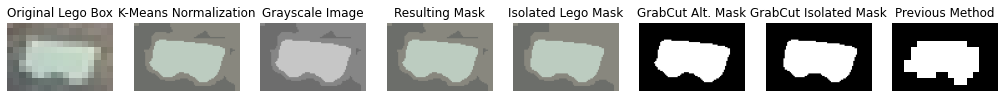

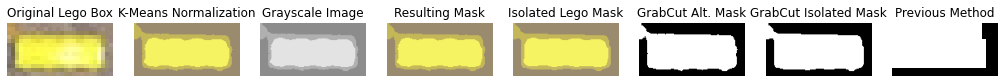

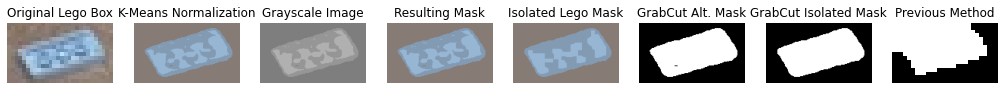

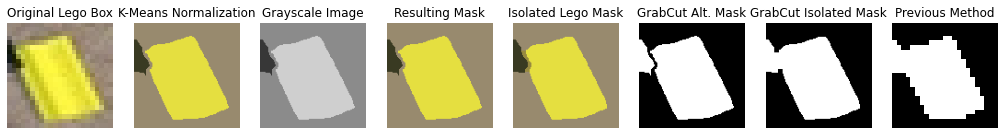

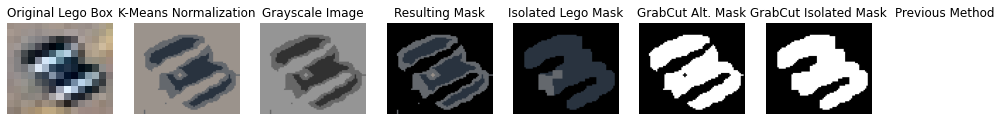

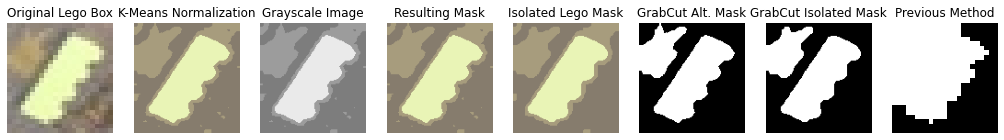

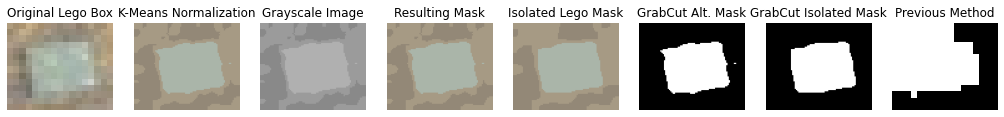

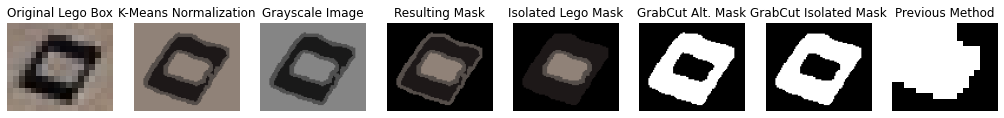

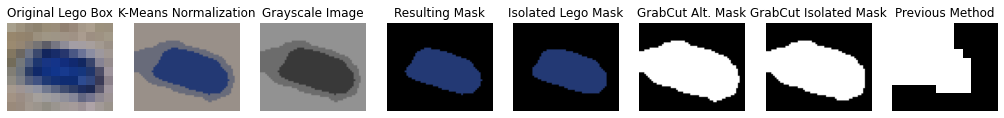

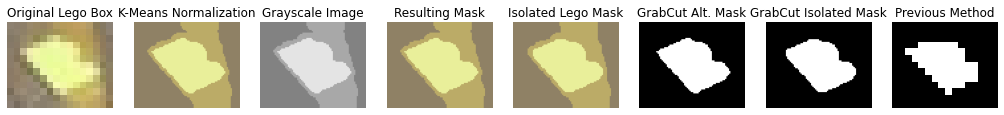

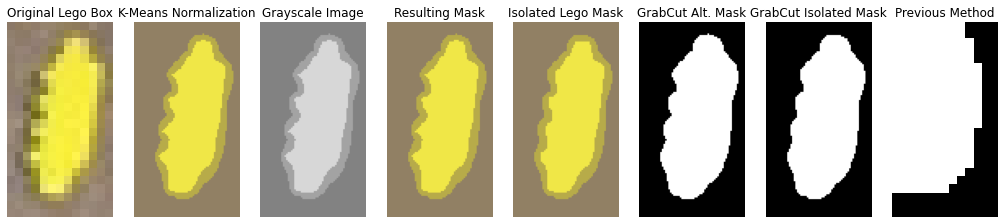

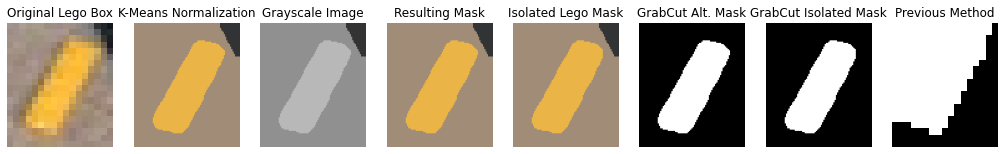

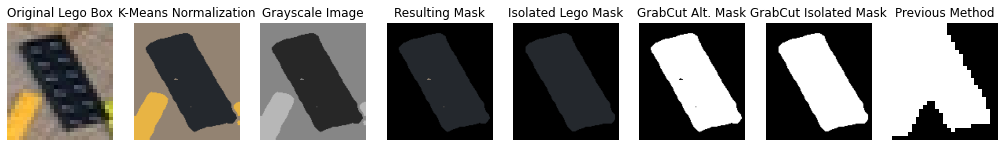

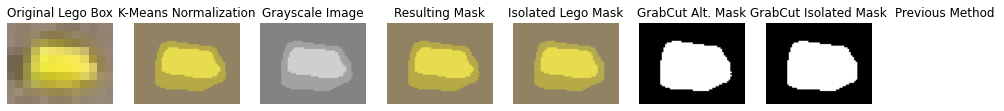

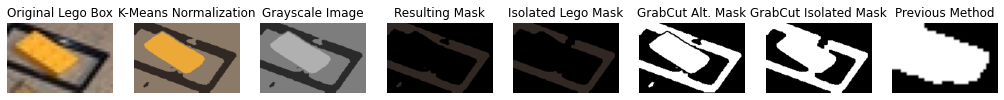

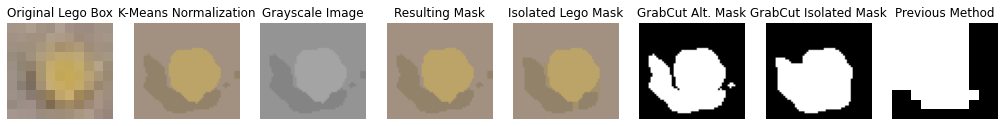

In [185]:



def CompareSegmentationMethods(img_path):
    image = cv2.imread(img_path)
    bb_imgs = GetBBImages(image, bbs_faster, 2) # add a padding of 2 pixels to the bounding box for better results

    for i in bb_imgs:

        # upscale the image for better results
        upscale = cv2.resize(i, (i.shape[1] * 5, i.shape[0] * 5)) 
        color_radius = 3
        upscale = kmeansBlur(upscale, 1, color_radius)

        fg_mask = GetGrabCutMask(upscale)
        gray = cv2.cvtColor(upscale, cv2.COLOR_BGR2GRAY)
        _, binary = cv2.threshold(gray, 2, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

        # Find contours in the binary image and draw mask
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        mask = np.zeros_like(gray)
        cv2.drawContours(mask, contours, -1, (255), thickness=cv2.FILLED)
        result = cv2.bitwise_and(upscale, upscale, mask=mask)

        # if result has small islands of pixels, remove them
        kernel = np.ones((3, 3), np.uint8)
        opening = cv2.morphologyEx(result, cv2.MORPH_OPEN, kernel, iterations=2)

        # if result has small holes in the middle, fill them
        closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=2)
        
        kernel = np.ones((3, 3), np.uint8)
        fg_mask2 = cv2.morphologyEx(fg_mask, cv2.MORPH_OPEN, kernel, iterations=2)

        # if result has small holes in the middle, fill them
        fg_mask2 = cv2.morphologyEx(fg_mask2, cv2.MORPH_CLOSE, kernel, iterations=2)

        plt.figure(figsize=(20, 10))
        plt.subplot(1, 9, 1)
        plt.title('Original Lego Box')
        plt.imshow(cv2.cvtColor(i, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        plt.subplot(1, 9, 2)
        plt.title('K-Means Normalization')
        plt.imshow(cv2.cvtColor(upscale, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        plt.subplot(1, 9, 3)
        plt.title('Grayscale Image')
        plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        plt.subplot(1, 9, 4)
        plt.title('Resulting Mask')
        plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        plt.subplot(1, 9, 5)
        plt.title('Isolated Lego Mask')
        plt.imshow(cv2.cvtColor(closing, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        
        plt.subplot(1, 9, 6)
        plt.title('GrabCut Alt. Mask')
        plt.imshow(cv2.cvtColor(fg_mask * 255, cv2.COLOR_BGR2RGB))
        plt.axis('off')
            
        plt.subplot(1, 9, 7)
        plt.title('GrabCut Isolated Mask')
        plt.imshow(cv2.cvtColor(fg_mask2 * 255, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        
        plt.subplot(1, 9, 8)
        plt.title('Mask-R-CNN Model Mask')
        plt.imshow(cv2.cvtColor(ModelSegmentation(upscale), cv2.COLOR_BGR2RGB))
        plt.axis('off')
        
        plt.subplot(1, 9, 8)
        plt.title('Previous Method')
        plt.imshow(cv2.cvtColor(ApplyLegoSegmentation(i) * 255, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        plt.show()
        
CompareSegmentationMethods(test_image)
